# Chapter 11. Training Deep Neural Networks


### The Vanishing/Exploding Gradients Problems


### Glorot and He Initialization

- By default, Keras uses Glorot initialization with a uniform distribution. When you create a layer, you can switch to He initialization by setting kernel_initializer="he_uniform" or kernel_initializer="he_normal" like this:


| Initialization | Activation functions                     | σ² (Normal) |
| -------------- | ---------------------------------------- | ----------- |
| Glorot         | None, tanh, sigmoid, softmax             | 1 / fan_avg |
| He             | ReLU, Leaky ReLU, ELU, GELU, Swish, Mish | 2 / fan_in  |
| LeCun          | SELU                                     | 1 / fan_in  |


In [1]:
import tensorflow as tf

dense = tf.keras.layers.Dense(50, activation="relu", kernel_initializer="he_normal")

- Alternatively, you can obtain any of the initializations listed in **Table** and more using the `VarianceScaling` initializer. For example, if you want **He initialization** with a uniform distribution and based on _fan_avg_ (rather than _fan_in_), you can use the following code:


In [2]:
he_avg_init = tf.keras.initializers.VarianceScaling(scale=2., mode="fan_avg", distribution="uniform")
dense = tf.keras.layers.Dense(
    50,
    activation="sigmoid",
    kernel_initializer=he_avg_init #Here it is...
)

### Better Activation Functions


#### Leaky ReLU

- Keras includes the classes LeakyReLU and PReLU in the tf.keras.layers package. Just like for other ReLU variants, you should use He initialization with these. For example:


In [3]:
leaky_Relu = tf.keras.layers.LeakyReLU(negative_slope=0.2)

dense = tf.keras.layers.Dense(50, activation=leaky_Relu, kernel_initializer="he_normal")

- If you prefer, you can also use LeakyReLU as a separate layer in your model; it makes no difference for training and predictions:


In [4]:
# model = tf.keras.models.Sequential([
#     [...], # more layers
#     tf.keras.layers.Dense(50, kernel_initializer="he_normal"), # no activation
#     tf.keras.layers.LeakyReLU(alpha=0.2), # activation as a separate layer
#     [...] # more layers
# ])

#### ELU and SELU


In [5]:
# ELU
dense = tf.keras.layers.Dense(50, activation="elu", kernel_initializer="he_normal")

In [6]:
#SELU
dense = tf.keras.layers.Dense(50, activation="selu", kernel_initializer="lecun_normal")

#### Batch Normalization

- Implementing batch normalization with Keras


- As with most things with Keras, implementing batch normalization is straightforward and intuitive. Just add a BatchNormalization layer before or after each hidden layer’s activation function. You may also add a BN layer as the first layer in your model, but a plain Normalization layer generally performs just as well in this location.


In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 784)            │         3,136 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 300)            │       235,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 300)            │         1,200 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 100)            │        30,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 271,346 (1.04 MB)

 Trainable params: 268,978 (1.03 MB)

 Non-trainable params: 2,368 (9.25 KB)

- Let’s look at the parameters of the first BN layer. Two are trainable (by backpropagation), and two are not:


In [9]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('gamma', True),
 ('beta', True),
 ('moving_mean', False),
 ('moving_variance', False)]

- The authors of the BN paper argued in favor of adding the BN layers before the activation functions, rather than after (as we just did). There is some debate about this, as which is preferable seems to depend on the task—you can experiment with this too to see which option works best on your dataset. To add the BN layers before the activation function, you must remove the activation functions from the hidden layers and add them as separate layers after the BN layers. Moreover, since a batch normalization layer includes one offset parameter per input, you can remove the bias term from the previous layer by passing use_bias=False when creating it. Lastly, you can usually drop the first BN layer to avoid sandwiching the first hidden layer between two BN layers. The updated code looks like this:


In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Input([28, 28]),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    tf.keras.layers.Dense(10, activation="softmax")
])

#### Gradient Clipping


In [11]:
optimizer = tf.keras.optimizers.SGD(clipvalue=1.0)  # Gradyan bileşenlerini sınırla
model.compile(optimizer=optimizer, loss="mse")

# veya gradyan normunu sınırla
optimizer = tf.keras.optimizers.SGD(clipnorm=1.0)
model.compile(optimizer=optimizer, loss="mse")

### Reusing Pretrained Layers


- If you have trained model, you can use it for another related model. It called Transfer Learning.


#### Transfer Learning with Keras


- First, you need to load model A and create a new model based on that model’s layers. You decide to reuse all the layers except for the output layer:


In [ ]:
[...] # Assuming model A was already trained and saved to "my_model_A"
model_A = tf.keras.models.load_model("my_model_A")
model_B_on_A = tf.keras.Sequential(model_A.layers[:-1])
model_B_on_A.add(tf.keras.layers.Dense(1, activation="sigmoid"))

- Note that model_A and model_B_on_A now share some layers. When you train model_B_on_A, it will also affect model_A. If you want to avoid that, you need to clone model_A before you reuse its layers. To do this, you clone model A’s architecture with clone_model(), then copy its weights:


In [ ]:
model_A_clone = tf.keras.models.clone_model(model_A)
model_A_clone.set_weigths(model_A.get_weights())

- Since the new output layer was initialized randomly it will make large errors (at least during the first few epochs), so there will be large error gradients that may wreck the reused weights. To avoid this, one approach is to freeze the reused layers during the first few epochs, giving the new layer some time to learn reasonable weights. To do this, set every layer’s trainable attribute to False and compile the model:


In [ ]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

* Now you can train the model for a few epochs, then unfreeze the reused layers (which requires compiling the model again) and continue training to fine-tune the reused layers for task B. After unfreezing the reused layers, it is usually a good idea to reduce the learning rate, once again to avoid damaging the reused weights.

In [ ]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4, validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True
    
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)

model_B_on_A.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16, validation_data=(X_valid_B, y_valid_B))

model_B_on_A.evaluate(X_test_B, y_test_B)

#### Unsupervised Pretraining

* Note that in the early days of deep learning it was difficult to train deep models, so people would use a technique called greedy layer-wise pretraining (depicted in Figure 11-6). They would first train an unsupervised model with a single layer, typically an RBM, then they would freeze that layer and add another one on top of it, then train the model again (effectively just training the new layer), then freeze the new layer and add another layer on top of it, train the model again, and so on. Nowadays, things are much simpler: people generally train the full unsupervised model in one shot and use autoencoders or GANs rather than RBMs.

### Faster Optimizers

* Another huge speed boost comes from using a faster optimizer than the regular gradient descent optimizer. In this section we will present the most popular optimization algorithms: momentum, Nesterov accelerated gradient, AdaGrad, RMSProp, and finally Adam and its variants.

#### Momentum

* Imagine a bowling ball rolling down a gentle slope on a smooth surface: it will start out slowly, but it will quickly pick up momentum until it eventually reaches terminal velocity (if there is some friction or air resistance). This is the core idea behind momentum optimization, In contrast, regular gradient descent will take small steps when the slope is gentle and big steps when the slope is steep, but it will never pick up speed. As a result, regular gradient descent is generally much slower to reach the minimum than momentum optimization.

In [20]:
optimizer = tf.keras.optimizers.SGD(
    learning_rate=0.001,
    momentum=0.9 #Critical Point
)
model.compile(optimizer=optimizer, loss="mse")

#### Nesterov Accelerated Gradient

* Nesterov momentum optimization, measures the gradient of the cost function not at the local position θ but slightly ahead in the direction of the momentum, at θ + βm

* This small tweak works because in general the momentum vector will be pointing in the right direction (i.e., toward the optimum), so it will be slightly more accurate to use the gradient measured a bit farther in that direction rather than the gradient at the original position.

* To use NAG, simply set nesterov=True when creating the SGD optimizer:

In [21]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

# Tek fark: nesterov=True parametresinin eklenmesidir.

#### Ada Grad

* Consider the elongated bowl problem again: gradient descent starts by quickly going down the steepest slope, which does not point straight toward the global optimum, then it very slowly goes down to the bottom of the valley. It would be nice if the algorithm could correct its direction earlier to point a bit more toward the global optimum. The AdaGrad algorithm⁠ achieves this correction by scaling down the gradient vector along the steepest dimensions.

#### RMProp

* As we’ve seen, AdaGrad runs the risk of slowing down a bit too fast and never converging to the global optimum. The RMSProp algorithm⁠ fixes this by accumulating only the gradients from the most recent iterations, as opposed to all the gradients since the beginning of training. It does so by using exponential decay in the first step.

* As you might expect, Keras has an RMSprop optimizer:

In [22]:
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

* Except on very simple problems, this optimizer almost always performs much better than AdaGrad. In fact, it was the preferred optimization algorithm of many researchers until Adam optimization came around.

#### Adam 🚀 (Most Used One)

* Adam,⁠ which stands for adaptive moment estimation, combines the ideas of momentum optimization and RMSProp: just like momentum optimization, it keeps track of an exponentially decaying average of past gradients; and just like RMSProp, it keeps track of an exponentially decaying average of past squared gradients (see Equation 11-9). These are estimations of the mean and (uncentered) variance of the gradients. The mean is often called the first moment while the variance is often called the second moment, hence the name of the algorithm.

In [24]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

# β1 ​(momentum katsayısı) genellikle 0.9
# β2 ​(RMSProp’un ölçekleme faktörü) genellikle 0.999

#### AdaMax

* In practice, this can make AdaMax more stable than Adam, but it really depends on the dataset, and in general Adam performs better. So, this is just one more optimizer you can try if you experience problems with Adam on some task.

#### Nadam

* Nadam optimization is Adam optimization plus the Nesterov trick, so it will often converge slightly faster than Adam. In his report introducing this technique,⁠ the researcher Timothy Dozat compares many different optimizers on various tasks and finds that Nadam generally outperforms Adam but is sometimes outperformed by RMSProp.

#### AdamW

* AdamW⁠ is a variant of Adam that integrates a regularization technique called weight decay. Weight decay reduces the size of the model’s weights at each training iteration by multiplying them by a decay factor such as 0.99. This may remind you of ℓ regularization, which also aims to keep the weights small, and indeed it can be shown mathematically that ℓ regularization is equivalent to weight decay when using SGD. However, when using Adam or its variants, ℓ regularization and weight decay are not equivalent: in practice, combining Adam with ℓ regularization results in models that often don’t generalize as well as those produced by SGD. AdamW fixes this issue by properly combining Adam with weight decay.

### Learning Rates Scheduling

* As discussed in Chapter 10, you can find a good learning rate by training the model for a few hundred iterations, exponentially increasing the learning rate from a very small value to a very large value, and then looking at the learning curve and picking a learning rate slightly lower than the one at which the learning curve starts shooting back up. You can then reinitialize your model and train it with that learning rate.

* But you can do better than a constant learning rate: if you start with a large learning rate and then reduce it once training stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. There are many different strategies to reduce the learning rate during training. It can also be beneficial to start with a low learning rate, increase it, then drop it again. These strategies are called learning schedules (I briefly introduced this concept in Chapter 4). These are the most commonly used learning schedules:

- Power scheduling
    * Set the learning rate to a function of the iteration number t: η(t) = η / (1 + t/s) . The initial learning rate η , the power c (typically set to 1), and the steps s are hyperparameters. The learning rate drops at each step. After s steps, the learning rate is down to η / 2. After s more steps it is down to η / 3, then it goes down to η / 4, then η / 5, and so on. As you can see, this schedule first drops quickly, then more and more slowly. Of course, power scheduling requires tuning η and s (and possibly c).

- Exponential scheduling
    * Set the learning rate to η(t) = η 0.1 . The learning rate will gradually drop by a factor of 10 every s steps. While power scheduling reduces the learning rate more and more slowly, exponential scheduling keeps slashing it by a factor of 10 every s steps.

- Piecewise constant scheduling
    * Use a constant learning rate for a number of epochs (e.g., η = 0.1 for 5 epochs), then a smaller learning rate for another number of epochs (e.g., η = 0.001 for 50 epochs), and so on. Although this solution can work very well, it requires fiddling around to figure out the right sequence of learning rates and how long to use each of them.

- Performance scheduling
    * Measure the validation error every N steps (just like for early stopping), and reduce the learning rate by a factor of λ when the error stops dropping.

- 1cycle scheduling
    * 1cycle was introduced in a 2018 paper by Leslie Smith.⁠ Contrary to the other approaches, it starts by increasing the initial learning rate η , growing linearly up to η halfway through training. Then it decreases the learning rate linearly down to η again during the second half of training, finishing the last few epochs by dropping the rate down by several orders of magnitude (still linearly). The maximum learning rate η is chosen using the same approach we used to find the optimal learning rate, and the initial learning rate η is usually 10 times lower. When using a momentum, we start with a high momentum first (e.g., 0.95), then drop it down to a lower momentum during the first half of training (e.g., down to 0.85, linearly), and then bring it back up to the maximum value (e.g., 0.95) during the second half of training, finishing the last few epochs with that maximum value. Smith did many experiments showing that this approach was often able to speed up training considerably and reach better performance. For example, on the popular CIFAR10 image dataset, this approach reached 91.9% validation accuracy in just 100 epochs, compared to 90.3% accuracy in 800 epochs through a standard approach (with the same neural network architecture). This feat was dubbed superconvergence.

* Implementing power scheduling in Keras is the easiest option—just set the decay hyperparameter when creating an optimizer:

In [28]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

# Burada decay =  1e−4, yani her adımda öğrenme oranı hafifçe azalır.

* Exponential scheduling and piecewise scheduling are quite simple too. You first need to define a function that takes the current epoch and returns the learning rate. For example, let’s implement exponential scheduling:

In [29]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 ** (epoch / 20)

# Epoch arttıkça öğrenme oranı küçülür, böylece model yavaşça en iyi hale gelir.

* If you do not want to hardcode η and s, you can create a function that returns a configured function:

In [ ]:
def exponential_decay(lr_0, s):
    def exponential_decay_fn(epoch):
        return lr_0 * 0.1 ** (epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr_0=0.01, s=20)

# lr_0 → Başlangıç öğrenme oranı
# s → Öğrenme oranı düşürme süresi


* Next, create a LearningRateScheduler callback, giving it the schedule function, and pass this callback to the fit() method:

In [ ]:
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

* The schedule function can optionally take the current learning rate as a second argument. For example, the following schedule function multiplies the previous learning rate by 0.1 , which results in the same exponential decay (except the decay now starts at the beginning of epoch 0 instead of 1):

In [33]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1 ** (1 / 20)

* For piecewise constant scheduling, you can use a schedule function like the following one (as earlier, you can define a more general function if you want; see the “Piecewise Constant Scheduling” section of the notebook for an example), then create a LearningRateScheduler callback with this function and pass it to the fit() method, just like for exponential scheduling:

In [35]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

* For performance scheduling, use the ReduceLROnPlateau callback. For example, if you pass the following callback to the fit() method, it will multiply the learning rate by 0.5 whenever the best validation loss does not improve for five consecutive epochs (other options are available; please check the documentation for more details):

In [ ]:
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)
history = model.fit(X_train, y_train, [...], callbacks=[lr_scheduler])

* Lastly, Keras offers an alternative way to implement learning rate scheduling: you can define a scheduled learning rate using one of the classes available in tf.keras.opti⁠ mizers.schedules, then pass it to any optimizer. This approach updates the learning rate at each step rather than at each epoch. For example, here is how to implement the same exponential schedule as the exponential_decay_fn() function we defined earlier:

In [ ]:
import math

batch_size = 32
n_epochs = 25
n_steps = n_epochs * math.ceil(len(X_train) / batch_size)

scheduled_learning_rate = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01, decay_steps=n_steps, decay_rate=0.1
)

optimizer = tf.keras.optimizers.SGD(learning_rate=scheduled_learning_rate)

### Avoiding Overfitting Through Regularization

* We already implemented one of the best regularization techniques in Chapter 10: early stopping. Moreover, even though batch normalization was designed to solve the unstable gradients problems, it also acts like a pretty good regularizer. In this section we will examine other popular regularization techniques for neural networks: ℓ and ℓ regularization, dropout, and maxnorm regularization.

#### ℓ1 and ℓ2 Regularization

* Just like you did in Chapter 4 for simple linear models, you can use ℓ regularization to constrain a neural network’s connection weights, and/or ℓ regularization if you want a sparse model (with many weights equal to 0). Here is how to apply ℓ regularization to a Keras layer’s connection weights, using a regularization factor of 0.01:

In [37]:
layer = tf.keras.layers.Dense(100, activation="relu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=tf.keras.regularizers.l2(0.01)
)

# Eğer L1 regularization istenirse:
# kernel_regularizer=tf.keras.regularizers.l1(0.01)

# Eğer hem L1 hem de L2 regularization istenirse:
# kernel_regularizer=tf.keras.regularizers.l1_l2(l1=0.01, l2=0.01)

* Since you will typically want to apply the same regularizer to all layers in your network, as well as using the same activation function and the same initialization strategy in all hidden layers, you may find yourself repeating the same arguments. This makes the code ugly and error-prone. To avoid this, you can try refactoring your code to use loops. Another option is to use Python’s functools.partial() function, which lets you create a thin wrapper for any callable, with some default argument values:

In [38]:
from functools import partial

RegularizedDense = partial(tf.keras.layers.Dense,
                           activation="relu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=tf.keras.regularizers.l2(0.01)
)

model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(100),
    RegularizedDense(100),
    tf.keras.layers.Dense(10, activation="softmax")
])


c:\Users\MRE\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Dropout

* It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability p of being temporarily “dropped out”, meaning it will be entirely ignored during this training step, but it may be active during the next step.

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
    kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(100, activation="relu",
    kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(10, activation="softmax")
])
[...] # compile and train the model

#### Monte Carlo (MC) Dropout

* It is the full implementation of MC dropout, boosting the dropout model we trained earlier without retraining it:

In [ ]:
import numpy as np
y_probas = np.stack([model(X_test, training=True) 
                     for sample in range(100)])

y_proba = y_probas.mean(axis=0)

* We just make 100 predictions over the test set, and we compute their average.

#### Max-Norm Regularization

* To implement max-norm regularization in Keras, set the kernel_constraint argument of each hidden layer to a max_norm() constraint with the appropriate max value, like this:

In [ ]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.constraints import max_norm

dense = Dense(100, activation="relu",
              kernel_initializer="he_normal",
              kernel_constraint=max_norm(1.))

# Exercises

* Practice training a deep neural network on the CIFAR10 image dataset:

* Build a DNN with 20 hidden layers of 100 neurons each (that’s too many, but it’s the point of this exercise). Use He initialization and the Swish activation function.

In [40]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    activation="swish",
                                    kernel_initializer="he_normal")
)

* Using Nadam optimization and early stopping, train the network on the CIFAR10 dataset. You can load it with `tf.keras.datasets.cifar10.load_data()`. The dataset is composed of 60,000 32 × 32–pixel color images (50,000 for training, 10,000 for testing) with 10 classes, so you'll need a softmax output layer with 10 neurons. Remember to search for the right learning rate each time you change the model's architecture or hyperparameters.*

In [41]:
model.add(tf.keras.layers.Dense(10, activation="softmax"))

* Let's use a Nadam optimizer with a learning rate of 5e-5. I tried learning rates 1e-5, 3e-5, 1e-4, 3e-4, 1e-3, 3e-3 and 1e-2, and I compared their learning curves for 10 epochs each (using the TensorBoard callback, below). The learning rates 3e-5 and 1e-4 were pretty good, so I tried 5e-5, which turned out to be slightly better.

In [42]:
optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-5)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"]
)

* Let's load the CIFAR10 dataset. We also want to use early stopping, so we need a validation set. Let's use the first 5,000 images of the original training set as the validation set:

In [43]:
cifar10 = tf.keras.datasets.cifar10.load_data()
(X_train_full, y_train_full), (X_test, y_test) = cifar10

X_train = X_train_full[5000:]
y_train = y_train_full[5000:]
X_valid = X_train_full[:5000]
y_valid = y_train_full[:5000]

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 240s 1us/step


* Now we can create the callbacks we need and train the model:

In [46]:
from pathlib import Path


early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_model.keras", save_best_only=True)

run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

In [47]:
model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

Epoch 1/100
1407/1407 ━━━━━━━━━━━━━━━━━━━━ 77s 38ms/step - accuracy: 0.1179 - loss: 8.1944 - val_accuracy: 0.1926 - val_loss: 2.1624
Epoch 2/100


KeyboardInterrupt: 

In [ ]:
model.evaluate(X_valid, y_valid)

* The model with the lowest validation loss gets about 46.8% accuracy on the validation set. It took 29 epochs to reach the lowest validation loss, with roughly 10 seconds per epoch on my laptop (without a GPU). Let's see if we can improve the model using Batch Normalization.

* Now try adding Batch Normalization and compare the learning curves: Is it converging faster than before? Does it produce a better model? How does it affect training speed?*

* The code below is very similar to the code above, with a few changes:

    * I added a BN layer after every Dense layer (before the activation     function), except for the output layer.
    * I changed the learning rate to 5e-4. I experimented with 1e-5, 3e-5,  5e-5, 1e-4, 3e-4, 5e-4, 1e-3 and 3e-3, and I chose the one with the  best validation performance after 20 epochs.
    * I renamed the run directories to run_bn_* and the model file name to  `my_cifar10_bn_model`.

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100, kernel_initializer="he_normal"))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.Activation("swish"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20,
                                                     restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_cifar10_bn_model.keras",
                                                         save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_bn_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

model.fit(X_train, y_train, epochs=100,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid, y_valid)

* *Is the model converging faster than before?* Much faster! The previous model took 29 epochs to reach the lowest validation loss, while the new model achieved that same loss in just 12 epochs and continued to make progress until the 17th epoch. The BN layers stabilized training and allowed us to use a much larger learning rate, so convergence was faster.
* *Does BN produce a better model?* Yes! The final model is also much better, with 50.7% validation accuracy instead of 46.7%. It's still not a very good model, but at least it's much better than before (a Convolutional Neural Network would do much better, but that's a different topic, see chapter 14).
* *How does BN affect training speed?* Although the model converged much faster, each epoch took about 15s instead of 10s, because of the extra computations required by the BN layers. But overall the training time (wall time) to reach the best model was shortened by about 10%.

* Try replacing Batch Normalization with SELU, and make the necessary adjustements to ensure the network self-normalizes (i.e., standardize the input features, use LeCun normal initialization, make sure the DNN contains only a sequence of dense layers, etc.).*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=7e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_selu_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_selu_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

This model reached the first model's validation loss in just 8 epochs. After 14 epochs, it reached its lowest validation loss, with about 50.3% accuracy, which is better than the original model (46.7%), but not quite as good as the model using batch normalization (50.7%). Each epoch took only 9 seconds. So it's the fastest model to train so far.

Try regularizing the model with alpha dropout. Then, without retraining your model, see if you can achieve better accuracy using MC Dropout.

**Warning**: there are now two versions of `AlphaDropout`. One is deprecated and also broken in some recent versions of TF, and unfortunately that's the version in the `tensorflow` library. Luckily, there's a perfectly fine version in the `keras` library (i.e., `keras`, not `tf.keras`). It's neither deprecated nor broken, so let's import and use that one:

In [ ]:
import keras.layers

tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.Nadam(learning_rate=5e-4)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(
    patience=20, restore_best_weights=True)
model_checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "my_cifar10_alpha_dropout_model.keras", save_best_only=True)
run_index = 1 # increment every time you train the model
run_logdir = Path() / "my_cifar10_logs" / f"run_alpha_dropout_{run_index:03d}"
tensorboard_cb = tf.keras.callbacks.TensorBoard(run_logdir)
callbacks = [early_stopping_cb, model_checkpoint_cb, tensorboard_cb]

X_means = X_train.mean(axis=0)
X_stds = X_train.std(axis=0)
X_train_scaled = (X_train - X_means) / X_stds
X_valid_scaled = (X_valid - X_means) / X_stds
X_test_scaled = (X_test - X_means) / X_stds

model.fit(X_train_scaled, y_train, epochs=100,
          validation_data=(X_valid_scaled, y_valid),
          callbacks=callbacks)

model.evaluate(X_valid_scaled, y_valid)

The model reaches 48.1% accuracy on the validation set. That's worse than without dropout (50.3%). With an extensive hyperparameter search, it might be possible to do better (I tried dropout rates of 5%, 10%, 20% and 40%, and learning rates 1e-4, 3e-4, 5e-4, and 1e-3), but probably not much better in this case.

Let's use MC Dropout now. We will need the `MCAlphaDropout` class we used earlier, so let's just copy it here for convenience:

In [ ]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

Now let's create a new model, identical to the one we just trained (with the same weights), but with `MCAlphaDropout` dropout layers instead of `AlphaDropout` layers:

In [ ]:
mc_model = tf.keras.Sequential([
    (
        MCAlphaDropout(layer.rate)
        if isinstance(layer, keras.layers.AlphaDropout)
        else layer
    )
    for layer in model.layers
])

Then let's add a couple utility functions. The first will run the model many times (10 by default) and it will return the mean predicted class probabilities. The second will use these mean probabilities to predict the most likely class for each instance:

In [ ]:
def mc_dropout_predict_probas(mc_model, X, n_samples=10):
    Y_probas = [mc_model.predict(X) for sample in range(n_samples)]
    return np.mean(Y_probas, axis=0)

def mc_dropout_predict_classes(mc_model, X, n_samples=10):
    Y_probas = mc_dropout_predict_probas(mc_model, X, n_samples)
    return Y_probas.argmax(axis=1)

Now let's make predictions for all the instances in the validation set, and compute the accuracy:

In [ ]:
tf.random.set_seed(42)

y_pred = mc_dropout_predict_classes(mc_model, X_valid_scaled)
accuracy = (y_pred == y_valid[:, 0]).mean()
accuracy

0.4984

We get back to roughly the accuracy of the model without dropout in this case (about 50.3% accuracy).

So the best model we got in this exercise is the Batch Normalization model.

### f.
*Exercise: Retrain your model using 1cycle scheduling and see if it improves training speed and model accuracy.*

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                    kernel_initializer="lecun_normal",
                                    activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD()
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

352/352 [==============================] - 3s 8ms/step - loss: nan - accuracy: 0.1706


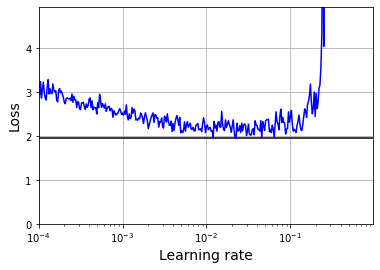

In [ ]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1,
                                   batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [ ]:
tf.random.set_seed(42)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=[32, 32, 3]))
for _ in range(20):
    model.add(tf.keras.layers.Dense(100,
                                 kernel_initializer="lecun_normal",
                                 activation="selu"))

model.add(keras.layers.AlphaDropout(rate=0.1))
model.add(tf.keras.layers.Dense(10, activation="softmax"))

optimizer = tf.keras.optimizers.SGD(learning_rate=2e-2)
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

In [ ]:
n_epochs = 15
n_iterations = math.ceil(len(X_train_scaled) / batch_size) * n_epochs
onecycle = OneCycleScheduler(n_iterations, max_lr=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/15
352/352 [==============================] - 3s 9ms/step - loss: 2.0559 - accuracy: 0.2839 - val_loss: 1.7917 - val_accuracy: 0.3768
Epoch 2/15
352/352 [==============================] - 3s 8ms/step - loss: 1.7596 - accuracy: 0.3797 - val_loss: 1.6566 - val_accuracy: 0.4258
Epoch 3/15
352/352 [==============================] - 3s 8ms/step - loss: 1.6199 - accuracy: 0.4247 - val_loss: 1.6395 - val_accuracy: 0.4260
Epoch 4/15
352/352 [==============================] - 3s 9ms/step - loss: 1.5451 - accuracy: 0.4524 - val_loss: 1.6202 - val_accuracy: 0.4408
Epoch 5/15
352/352 [==============================] - 3s 8ms/step - loss: 1.4952 - accuracy: 0.4691 - val_loss: 1.5981 - val_accuracy: 0.4488
Epoch 6/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4541 - accuracy: 0.4842 - val_loss: 1.5720 - val_accuracy: 0.4490
Epoch 7/15
352/352 [==============================] - 3s 9ms/step - loss: 1.4171 - accuracy: 0.4967 - val_loss: 1.6035 - val_accuracy: 0.4470
Epoch 

One cycle allowed us to train the model in just 15 epochs, each taking only 2 seconds (thanks to the larger batch size). This is several times faster than the fastest model we trained so far. Moreover, we improved the model's performance (from 50.7% to 52.0%).